# Assignment 2 - Predictive Process Monitoring

**Due: Wednesday, 11 December, 2024 at 17:00 CET**

In this assignment, you will learn to train a regression model to predict the remaining time of a process. Additionally, you will demonstrate your ability to evaluate the model's performance and discuss the results in a report. The learning objectives of this assignment are to:

- Apply data cleaning, data transformation, and feature encoding techniques to preprocess event data.
- Use regression models to predict the remaining time of ongoing cases.
- Calculate model performance metrics (e.g., MAE, MSE, RMSE, \(R^2\), etc.).
- Refine the experimental design to compare the performance of different preprocessing and encoding methods.
- Reflect on the differences between various methods and their effect on the model performance.


## Tasks Overview

This assignment includes six tasks:

1. **Data Exploration:** Perform data exploration to understand the dataset.
2. **Data Preprocessing and Trace Encoding:** Apply data preprocessing and trace encoding (covered during Lectures 5 and 7).
3. **Regression Model Training:** Select a regression algorithm of interest and train a regression model (a regressor) to forecast the remaining time of each case after each event (see Lecture 6)
4. **Prefix-Length Buckets:** Create buckets of different prefix lengths and train a separate regressor for each bucket (covered during Lectures 5 and 7).
5. **Alternative Methods:** Revisit your design decisions and investigate two additional methods that may improve model performance.
6. **Evaluation:** Evaluate the results.

### Notes

- You may reuse your code from Tasks 2 and 3 in Tasks 4 and 5.
- For Task 6 and your report, ensure that you save all the calculated metrics (MAE, MSE, RMSE, and \(R^2\)) in previous tasks. Save these metrics in a list or dictionary to facilitate easy evaluation and comparison of results.




## Task 1: Exploring the data set



### Data set: Sepsis

Import the file *Complete Sepsis.csv* to load the Sepsis data set. This real-life event log contains events of sepsis cases from a hospital. Sepsis is a life threatening condition typically caused by an infection. One case represents a patient's pathway through the treatment process. The events were recorded by the ERP (Enterprise Resource Planning) system of the hospital. The original data set contains about 1000 cases with in total 15,000 events that were recorded for 16 different activities. Moreover, 39 data attributes are recorded, e.g., the group responsible for the activity, the results of tests and information from checklists. 

Additional information about the data can be found :
- https://data.4tu.nl/articles/dataset/Sepsis_Cases_-_Event_Log/12707639
- http://ceur-ws.org/Vol-1859/bpmds-08-paper.pdf




In [14]:
# Import packages
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Import data
# TODO: Change the file path to your file path
data_Sepsis = pd.read_csv("./Complete Sepsis.csv", sep=",")

# create an overview of the data
print(data_Sepsis.describe())
print(f"\n Dataset columns \n",data_Sepsis.columns)
# print(data_Sepsis.head())

# Print the activities that occurred in the process
print(f"\n Unique activities \n",data_Sepsis['Activity'].unique())
print(f"\n The data shape is",data_Sepsis.shape)
# Print the cases (patients) that are following the process
print(f"unique Case-ID's", data_Sepsis['Case ID'].unique())

# for variable in data_Sepsis.columns:
#     print(variable)
#     print(data_Sepsis[variable].unique())

       Variant index         Age   Leucocytes          CRP   LacticAcid
count   13333.000000  777.000000  3075.000000  2884.000000  1281.000000
mean      360.079127   71.833977    12.985463   114.368585     1.902420
std       214.255001   15.573718    15.512797    86.366989     1.442281
min         1.000000   20.000000     0.200000     5.000000     0.200000
25%       176.000000   60.000000     7.700000    44.000000     1.100000
50%       360.000000   75.000000    10.900000    96.000000     1.500000
75%       547.000000   85.000000    15.000000   163.000000     2.200000
max       728.000000   90.000000   381.300000   573.000000    14.900000

 Dataset columns 
 Index(['Case ID', 'Activity', 'Complete Timestamp', 'Variant', 'Variant index',
       'lifecycle:transition', 'org:group', 'InfectionSuspected',
       'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie',
       'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'Age',
       'DiagnosticIC', 'DiagnosticSputum'

### Create the Labels by Calculating the Remaining Time

To forecast the remaining time for each patient in the hospital, we group the events by patient, use the completion time of each patient (i.e., the timestamp of the last event for each patient), and calculate the time difference between the current event and the completion time. This is done for each event. As a result, we now have our labels, which indicate how long a patient will remain in the treatment process for each event.

To help you get started, we created the target variable *remaining_time(days)* for you. 

In [15]:
df = data_Sepsis.copy()

# Convert the timestamp column to datetime
df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'])

# Find the completion time for each case
completion_times = df.groupby('Case ID')['Complete Timestamp'].max().rename('completion_time')

# Merge completion time back into the original DataFrame
df = df.merge(completion_times, on='Case ID')

# Calculate the remaining time for each event
df['remaining_time'] = df['completion_time'] - df['Complete Timestamp']


# Calculate the remaining time for each event in days
df['remaining_time(days)'] = df['remaining_time'].dt.total_seconds()/60/60/24

# Retain rows where the remaining time is larger than 0 days. 
df = df[df['remaining_time(days)'] > 0]

# Drop the completion_time column to avoid information leakage
df = df.drop(columns=['completion_time'])

# Drop the remaining_time column to avoid information leakage
df = df.drop(columns=['remaining_time'])

# Display the result
label_column = 'remaining_time(days)'

# print(df['remaining_time(days)'].describe())
print(df['remaining_time(days)'].describe())

# Fill in the column names of case id, activity, and time stamps
column_Sepsis_CaseID = 'Case ID' 
column_Sepsis_Activity = 'Activity'
column_Sepsis_Timestamps = 'Complete Timestamp'

count    12533.000000
mean        39.211322
std         65.338164
min          0.013854
25%          4.522025
50%         11.043669
75%         41.963102
max        422.323947
Name: remaining_time(days), dtype: float64


In [16]:
df.head(n=20)

,Case ID,Activity,Complete Timestamp,Variant,Variant index,lifecycle:transition,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,...,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid,remaining_time(days)
0,A,ER Registration,2014-10-22 11:15:41,Variant 35,35,complete,A,True,True,True,...,False,True,A,False,True,True,NaN,NaN,NaN,11.166192
1,A,Leucocytes,2014-10-22 11:27:00,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN,11.158333
2,A,CRP,2014-10-22 11:27:00,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN,11.158333
3,A,LacticAcid,2014-10-22 11:27:00,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,11.158333
4,A,ER Triage,2014-10-22 11:33:37,Variant 35,35,complete,C,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.153738
5,A,ER Sepsis Triage,2014-10-22 11:34:00,Variant 35,35,complete,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.153472
6,A,IV Liquid,2014-10-22 14:03:47,Variant 35,35,complete,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.049456
7,A,IV Antibiotics,2014-10-22 14:03:47,Variant 35,35,complete,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.049456
8,A,Admission NC,2014-10-22 14:13:19,Variant 35,35,complete,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.042836
9,A,CRP,2014-10-24 09:00:00,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.0,NaN,9.260417



### 1.1 Exploratory data analysis

For the data set, create 2-3 figures/tables that help you understand the data 

Note that some of these variables are categorical variables and some are numberical. Additionally, some of the variables have missing values. Think/discuss how would you preprocess these variables.


Make sure to at least check each variable's data type and understand their distribution. 

*For creating data visualizations, you may consider using the matplot library and visit the [matplot gallery](https://matplotlib.org/stable/gallery/index.html) for inspiration (e.g., histograms for distribution, or heatmaps for feature correlation).*

In [17]:
# import packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# TODO: plot figure(s)
remaining_time_x_activity = px.box(df, x='Activity', y='remaining_time(days)')
remaining_time_x_activity.show()

group_count = px.histogram(df, x="org:group")
group_count.show()

heatmap = px.density_heatmap(df, x='CRP', y='remaining_time(days)')
heatmap.show()

### (Optional) 1.2 Process Discovery and Visualization 

This is an optional task to show you how process discovery and visualizaion can be deployed using the pm4py library. 

(*The following code requires the graphviz library to be installed. If you have issues with installing the graphviz, you may try to follow the instructions on Install GraphViz on the [pm4py](https://pm4py.fit.fraunhofer.de/install-page) install page*)

The following code:
- fill in the columns for case id, activity, and timestamps
- convert the data set into an event log
- discover a Directly-follows graph (DFG) and a process model for each event log. 
- you may use the discovered process model in your report



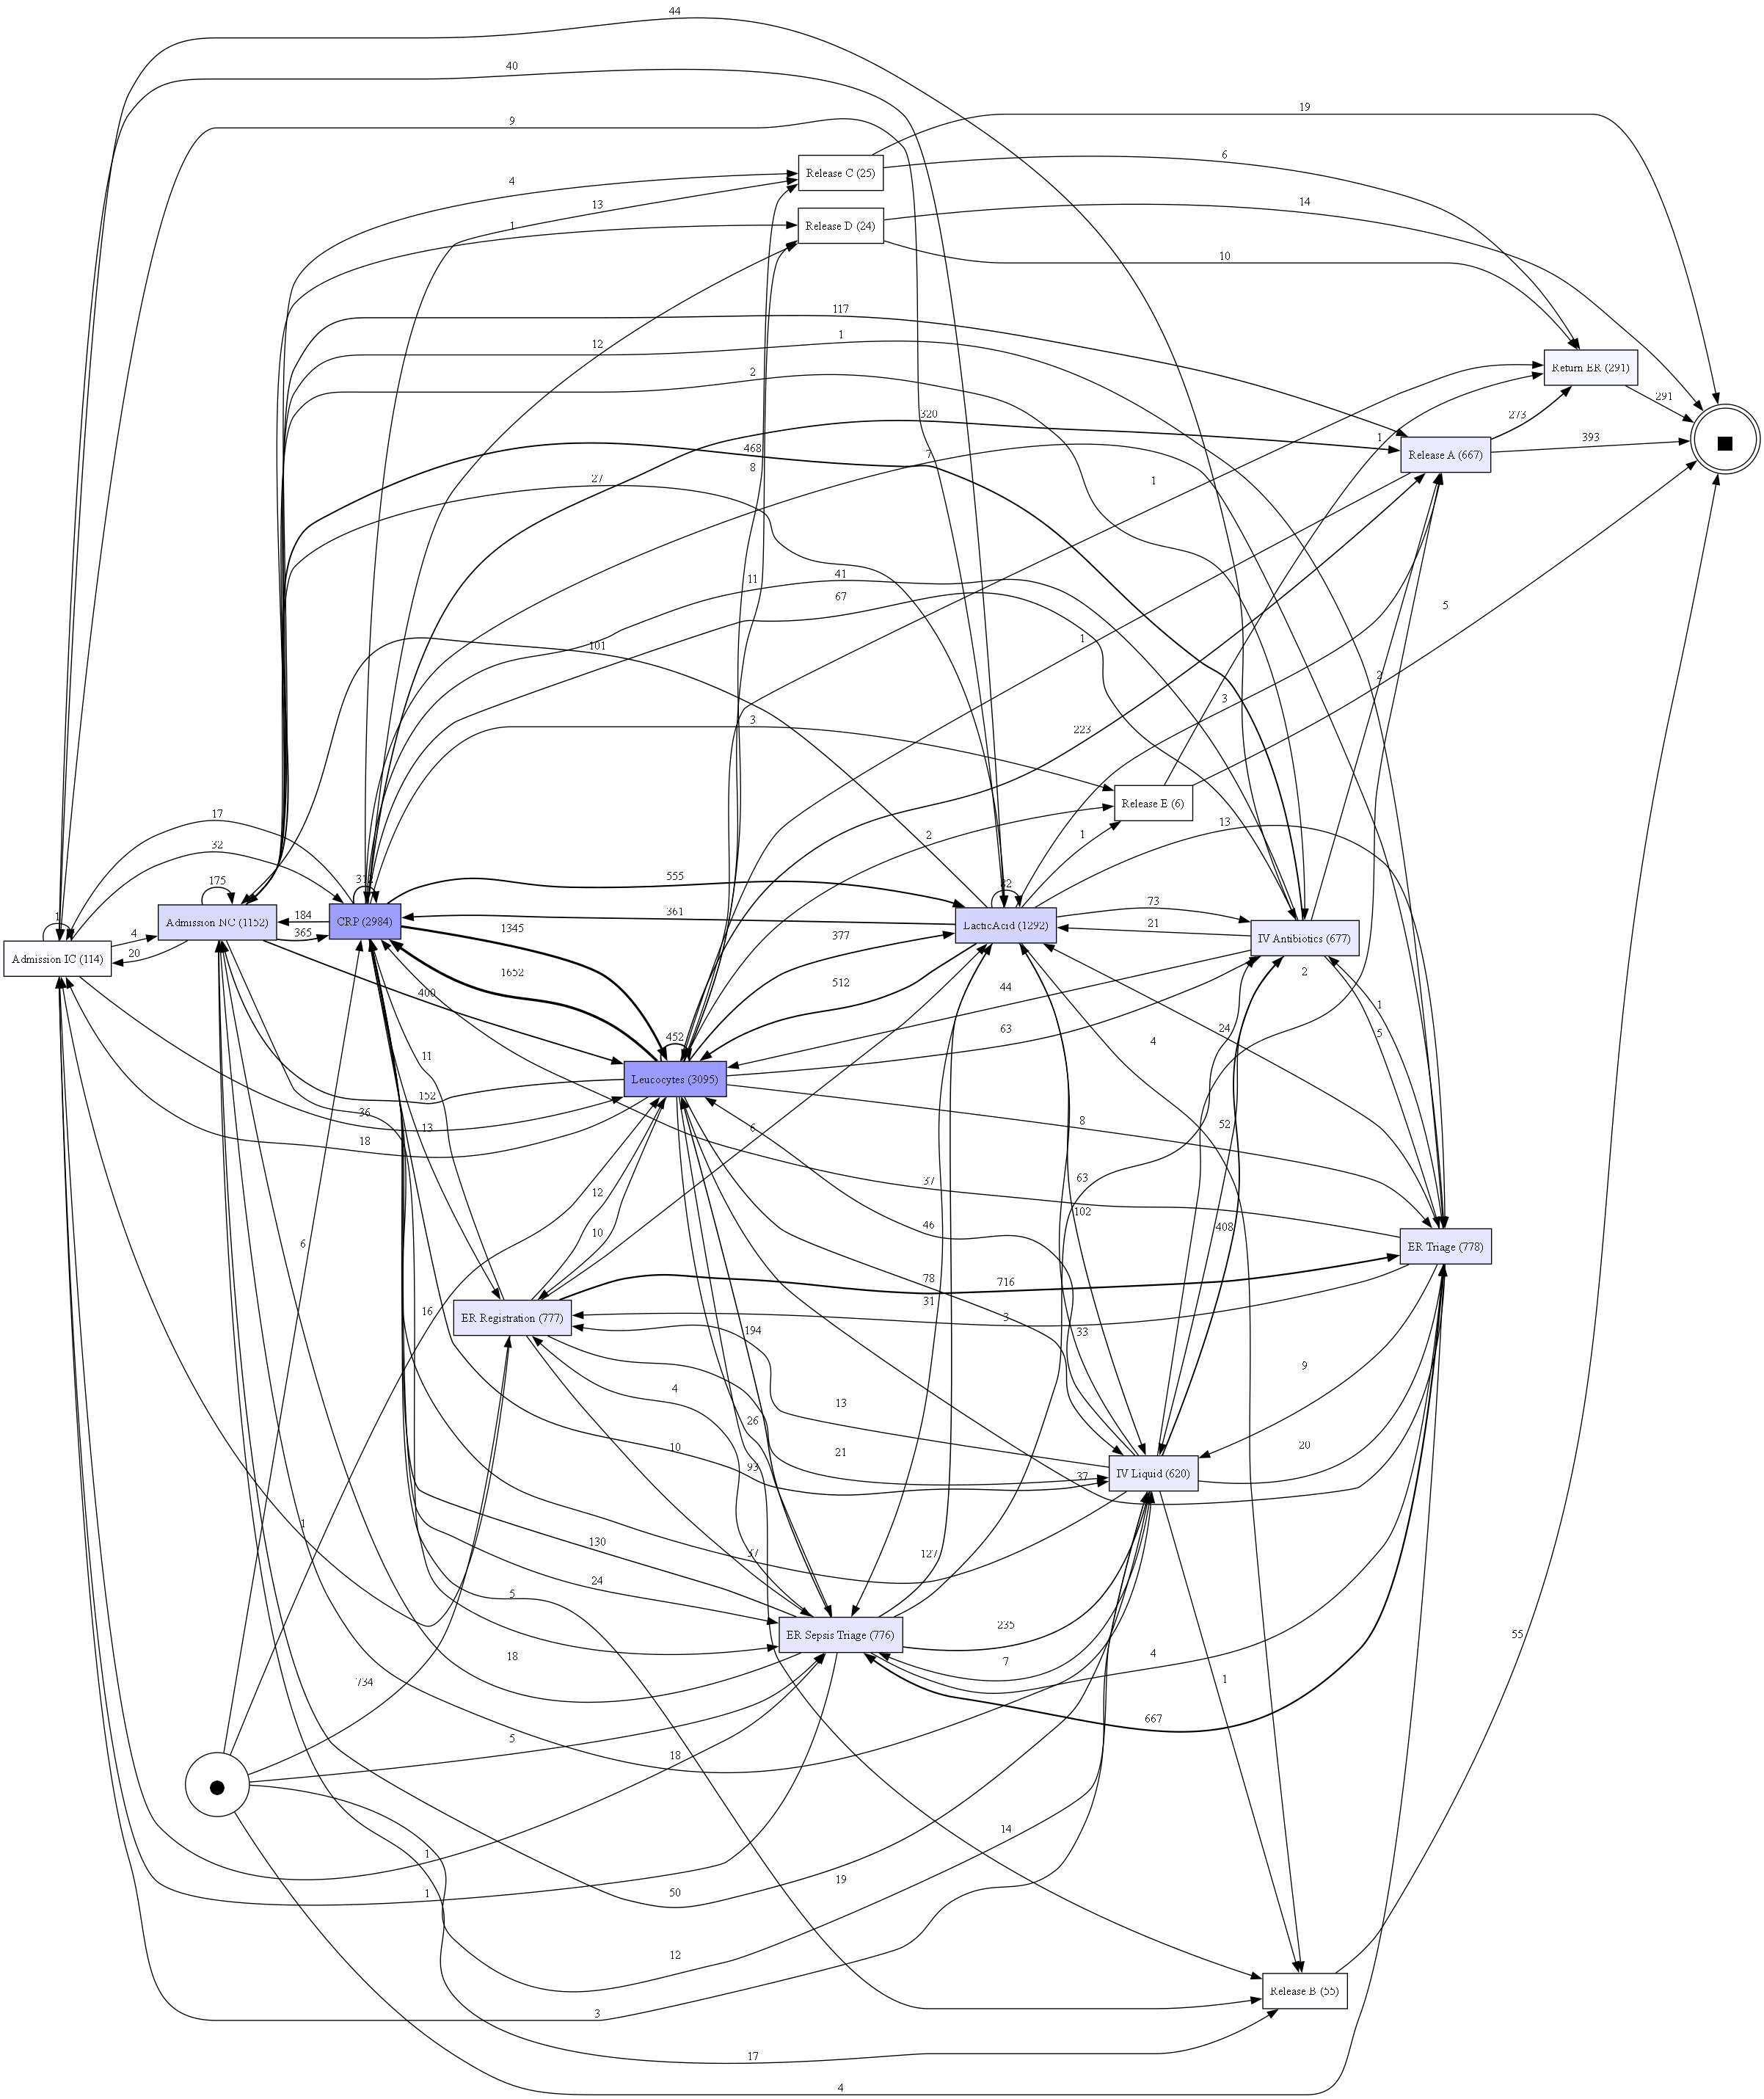

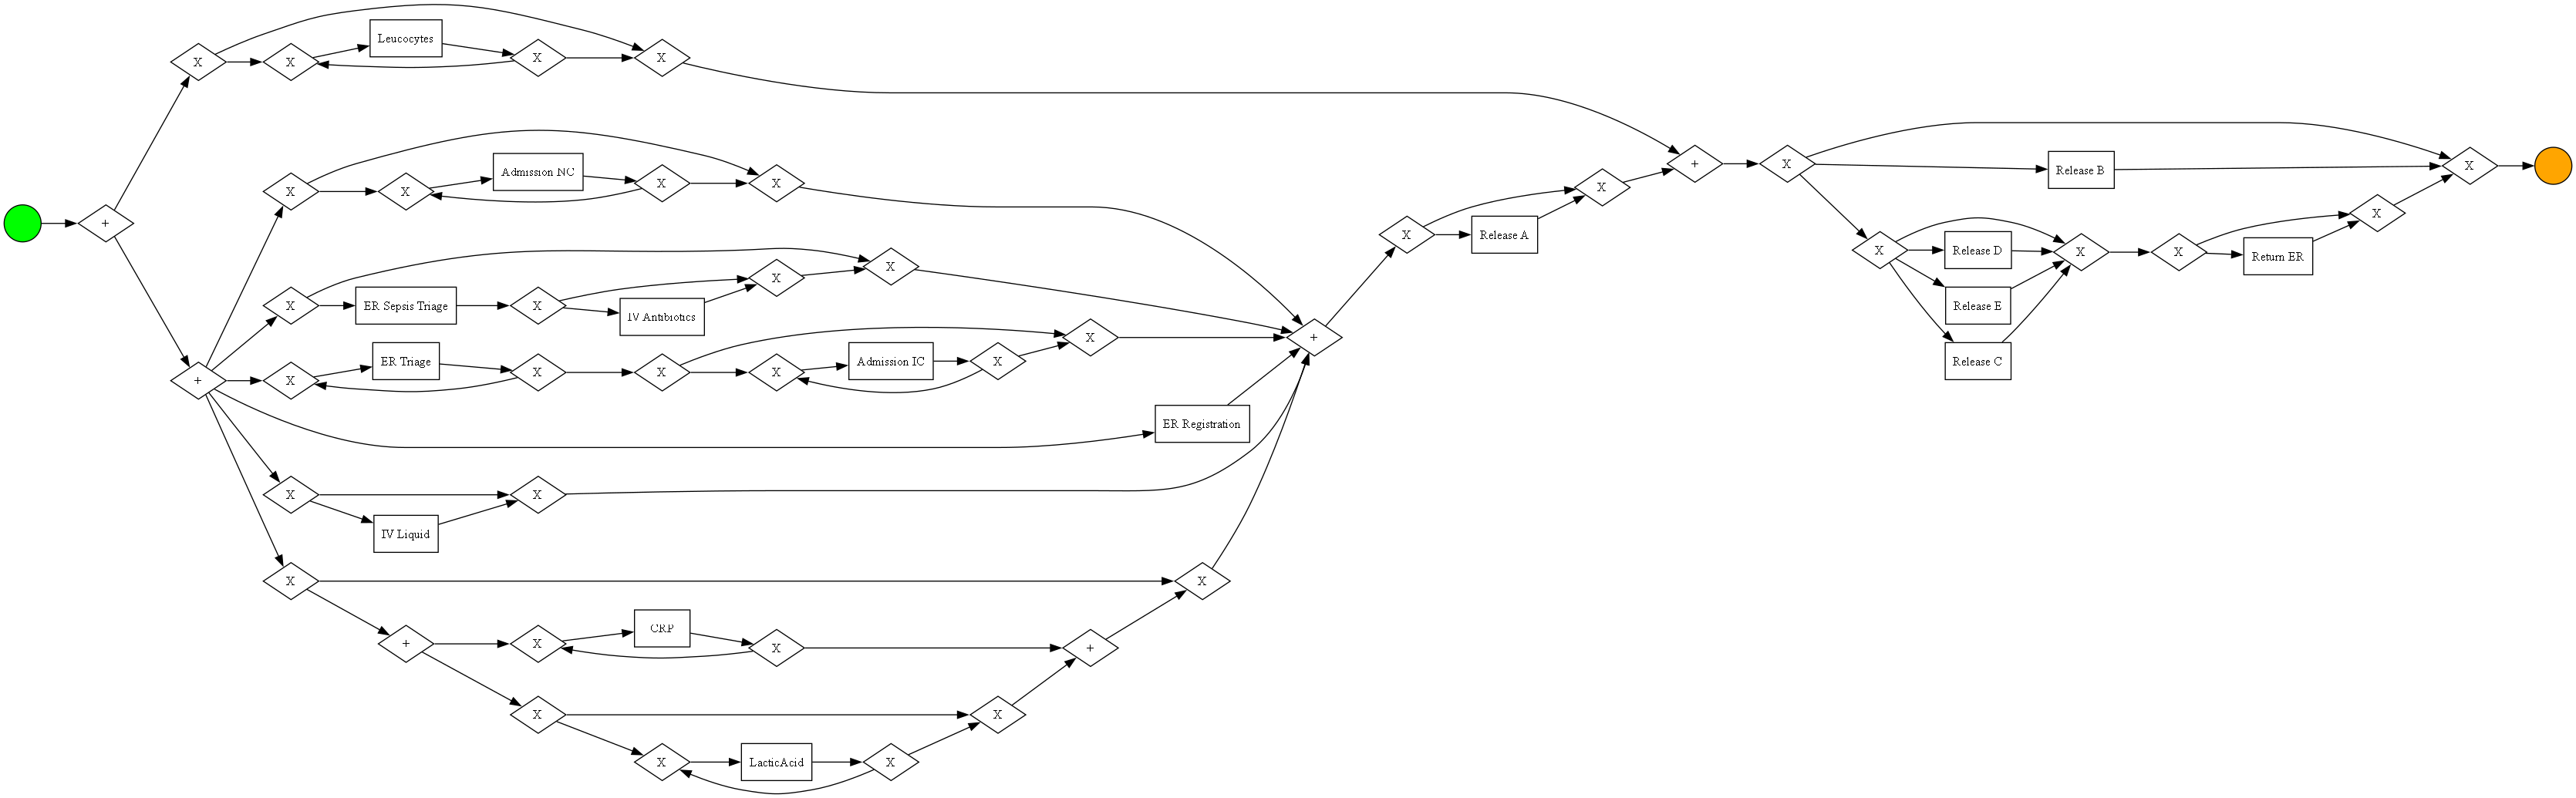

In [18]:
# If you have brew installed, install graphviz brew install graphviz
# Then install pm4py library and graphviz library using pip install 
# !pip install -U pm4py
# !conda install graphviz
# !conda install python-graphviz
import pm4py

data_Sepsis[column_Sepsis_CaseID] = data_Sepsis[column_Sepsis_CaseID].astype(str)

data_Sepsis_copy = data_Sepsis.copy()
data_Sepsis_copy['Complete Timestamp'] = pd.to_datetime(data_Sepsis_copy['Complete Timestamp'])

# Convert the data to an event log
log_Sepsis = pm4py.format_dataframe(data_Sepsis_copy, case_id=column_Sepsis_CaseID, activity_key=column_Sepsis_Activity, timestamp_key=column_Sepsis_Timestamps)

# Set the log to be the one that you are interested
log = log_Sepsis

# Create a Directly-Follows Graph (DFG) and plot this graph
dfg, start_activities, end_activities = pm4py.discover_dfg(log)
pm4py.view_dfg(dfg, start_activities, end_activities)

# Discover a Process Model using Inductive Miner and plot this BPMN model
process_tree = pm4py.discover_process_tree_inductive(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.view_bpmn(bpmn_model)

## Task 2: Preprocessing and Trace Encoding

### 2.1 Data preprocessing

In the previous data exploration task, you gathered some initial insights about the dataset. Based on your observations during data exploration, decide which preprocessing steps are necessary (e.g., handling missing values, encoding categorical variables, scaling numerical features, etc.) and implement them accordingly.

In [19]:
### 2.1 Data preprocessing

# TODO: decide on how you handle missing values (ranging from dropping columns and dropping rows to filling in the empty cells)

# Check for missing values per column
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Calculate percentage of missing values per column
missing_percentage = df.isnull().sum() * 100 / len(df)
print("\nPercentage of missing values per column:")
print(missing_percentage)

# Essential columns: 'Case ID', 'Activity', 'Complete Timestamp', 'remaining_time(days)'
# Drop rows where these columns have missing values
df = df.dropna(subset=['Case ID', 'Activity', 'Complete Timestamp', 'remaining_time(days)'])

# Ensure 'Complete Timestamp' is in datetime format
df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'])

# Now, handle missing values column by column, with detailed explanations

# List of numerical columns
numerical_cols = ['Age', 'Leucocytes', 'CRP', 'LacticAcid']

# List of binary columns (should be True/False or 1/0)
binary_cols = ['InfectionSuspected', 'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie',
               'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'DiagnosticIC', 'DiagnosticSputum',
               'DiagnosticLiquor', 'DiagnosticOther', 'SIRSCriteria2OrMore', 'DiagnosticXthorax',
               'SIRSCritTemperature', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos', 'Oligurie',
               'DiagnosticLacticAcid', 'Diagnose', 'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG']

# List of categorical columns
categorical_cols = ['Variant', 'Variant index', 'lifecycle:transition', 'org:group']

# Handle numerical columns
for col in numerical_cols:
    if col in df.columns:
        missing_pct = missing_percentage[col]
        print(f"\nColumn '{col}' has {missing_pct:.2f}% missing values")
        if missing_pct > 50:
            # Drop the column if more than 50% missing values
            print(f"Dropping '{col}' column due to high percentage of missing values")
            df.drop(columns=[col], inplace=True)
        else:
            # Fill missing values with median
            median_value = df[col].median()
            df[col] = df[col].fillna(median_value)
            print(f"Filled missing values in '{col}' with median value {median_value}")
            # Convert to numeric type
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle binary columns
for col in binary_cols:
    if col in df.columns:
        missing_pct = missing_percentage[col]
        print(f"\nColumn '{col}' has {missing_pct:.2f}% missing values")
        if missing_pct > 50:
            # Drop the column if more than 50% missing values
            print(f"Dropping '{col}' column due to high percentage of missing values")
            df.drop(columns=[col], inplace=True)
        else:
            # Fill missing values with mode (most frequent value)
            mode_value = df[col].mode()[0]
            df[col] = df[col].fillna(mode_value)
            print(f"Filled missing values in '{col}' with mode value '{mode_value}'")
            # Convert to integer type
            df[col] = df[col].astype(int)

# Handle categorical columns
for col in categorical_cols:
    if col in df.columns:
        missing_pct = missing_percentage[col]
        print(f"\nColumn '{col}' has {missing_pct:.2f}% missing values")
        if missing_pct > 50:
            # Drop the column if more than 50% missing values
            print(f"Dropping '{col}' column due to high percentage of missing values")
            df.drop(columns=[col], inplace=True)
        else:
            # Fill missing values with mode (most frequent value)
            mode_value = df[col].mode()[0]
            df[col] = df[col].fillna(mode_value)
            print(f"Filled missing values in '{col}' with mode value '{mode_value}'")

# Encode categorical variables
# One-hot encode 'org:group' and 'Variant' if they exist
if 'org:group' in df.columns:
    print("\nOne-hot encoding 'org:group' column")
    org_group_dummies = pd.get_dummies(df['org:group'], prefix='org_group')
    df = pd.concat([df, org_group_dummies], axis=1)
    df.drop(['org:group'], axis=1, inplace=True)

if 'Variant' in df.columns:
    print("\nOne-hot encoding 'Variant' column")
    variant_dummies = pd.get_dummies(df['Variant'], prefix='Variant')
    df = pd.concat([df, variant_dummies], axis=1)
    df.drop(['Variant'], axis=1, inplace=True)

# Process 'Variant index' column
if 'Variant index' in df.columns:
    print("\nProcessing 'Variant index' column")
    df['Variant index'] = pd.to_numeric(df['Variant index'], errors='coerce')
    missing_pct = df['Variant index'].isnull().sum() * 100 / len(df)
    if missing_pct > 50:
        print(f"Dropping 'Variant index' column due to {missing_pct:.2f}% missing values")
        df.drop(columns=['Variant index'], inplace=True)
    else:
        median_value = df['Variant index'].median()
        df['Variant index'] = df['Variant index'].fillna(median_value)
        df['Variant index'] = df['Variant index'].astype(int)
        print(f"Filled missing values in 'Variant index' with median value {median_value}")

# Scale numerical features
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Get the list of numerical columns that are still in df
numerical_cols_in_df = [col for col in numerical_cols if col in df.columns]

# Scale numerical columns
if numerical_cols_in_df:
    df[numerical_cols_in_df] = scaler.fit_transform(df[numerical_cols_in_df])
    print(f"\nScaled numerical columns: {numerical_cols_in_df}")

# Save the resulting DataFrame to a CSV file
output_filename = "2.1.csv"
df.to_csv(output_filename, index=False)

print("\nData after preprocessing:")
print(df.head())

Missing values per column:
Case ID                          0
Activity                         0
Complete Timestamp               0
Variant                          0
Variant index                    0
lifecycle:transition             0
org:group                        0
InfectionSuspected           11757
DiagnosticBlood              11757
DisfuncOrg                   11757
SIRSCritTachypnea            11757
Hypotensie                   11757
SIRSCritHeartRate            11757
Infusion                     11757
DiagnosticArtAstrup          11757
Age                          11757
DiagnosticIC                 11757
DiagnosticSputum             11757
DiagnosticLiquor             11757
DiagnosticOther              11757
SIRSCriteria2OrMore          11757
DiagnosticXthorax            11757
SIRSCritTemperature          11757
DiagnosticUrinaryCulture     11757
SIRSCritLeucos               11757
Oligurie                     11757
DiagnosticLacticAcid         11757
Diagnose                    

### 2.2 Trace Encoding


- Implement the aggregation encoding for the data set (for example, see [1], Table 6)

<span style="color:gray">[1] Ilya Verenich, Marlon Dumas, Marcello La Rosa, Fabrizio Maria Maggi, Irene Teinemaa:
Survey and Cross-benchmark Comparison of Remaining Time Prediction Methods in Business Process Monitoring. ACM Trans. Intell. Syst. Technol. 10(4): 34:1-34:34 (2019) [Section 1, 2, 4.1, 4.3, 4.6, 5.2, 5.3, 5.4, and 6] </span>

This encoding has been discussed during lecture 7.
- for the aggregation encoding check the pandas groupby.DataFrameGroupBy and cumsum function and read the [examples and answers on the stake overflow](https://stackoverflow.com/a/49578219)

In [20]:
# TODO: Implement the function that returns the aggregation state encoding of a log
def agg_per_event_encoding(dataFrame, columnCase, columnActivity, numerical_cols):
    _new_data = dataFrame.copy()
    
    # TODO: Apply one-hot encoding to the 'Activity' column
    # One-hot encode the 'Activity' column to create activity features
    onehot = pd.get_dummies(_new_data[columnActivity], prefix='act')
    
    # TODO: Group by 'case id' and compute the cumulative sum for each activity
    # Compute cumulative counts of activities per case
    cumulative_freq = onehot.groupby(_new_data[columnCase]).cumsum()
    
    # Compute time since case start for each event
    _new_data['elapsed_time'] = _new_data.groupby(columnCase)['Complete Timestamp'].transform(lambda x: x - x.min())
    _new_data['elapsed_time'] = _new_data['elapsed_time'].dt.total_seconds() / 3600  # in hours 
    # Compute cumulative averages of numerical variables per case
    cumulative_numerical = _new_data.groupby(columnCase)[numerical_cols].expanding().mean().reset_index(level=0, drop=True)
    cumulative_numerical.columns = [f'cumulative_mean_{col}' for col in numerical_cols]
    
    # TODO: Concatenate the original DataFrame with the cumulative frequencies and cumulative numerical features
    _data_with_features = pd.concat([_new_data.reset_index(drop=True), cumulative_freq.reset_index(drop=True), cumulative_numerical.reset_index(drop=True)], axis=1)
    
    return _data_with_features

# For the data set, apply the aggregated state encoding
numerical_cols_in_df = [col for col in numerical_cols if col in df.columns]
data_Sepsis_ag = agg_per_event_encoding(df, column_Sepsis_CaseID, column_Sepsis_Activity, numerical_cols_in_df)
print("\nData after trace encoding:")
print(data_Sepsis_ag.head())


Data after trace encoding:
  Case ID         Activity  Complete Timestamp  Variant index  \
0       A  ER Registration 2014-10-22 11:15:41             35   
1       A       Leucocytes 2014-10-22 11:27:00             35   
2       A              CRP 2014-10-22 11:27:00             35   
3       A       LacticAcid 2014-10-22 11:27:00             35   
4       A        ER Triage 2014-10-22 11:33:37             35   

  lifecycle:transition  remaining_time(days)  org_group_A  org_group_B  \
0             complete             11.166192         True        False   
1             complete             11.158333        False         True   
2             complete             11.158333        False         True   
3             complete             11.158333        False         True   
4             complete             11.153738        False        False   

   org_group_C  org_group_D  ...  act_ER Sepsis Triage  act_ER Triage  \
0        False        False  ...                     0         

### 2.3 Create training and test data sets using temporal split


Choose the size of your test data and use that to find the appropiate date (time threshold) to split the dataset into training  and test set.

This approach is commonly used for time-series or event log data to ensure that training data comes from earlier time periods and test data from later periods. This avoids data leakage, where future data might influence the training process.

When writing your report, explain how you split the data and provide a justification for your choice as part of the experiment setup discussion.

In [21]:
# Define time threshold
time_threshold = pd.Timestamp('2014-09-30 00:00:00')

irrelevant_Sepsis_Columns = [column_Sepsis_CaseID,
                             column_Sepsis_Activity, column_Sepsis_Timestamps, label_column, 'case_start_time', 'lifecycle:transition', 'Diagnose' ]

def clean_up_removal(data_frame, irrelevant_columns):
    return data_frame[[col for col in data_frame.columns if col not in irrelevant_columns]]
    
def clean_up_keep(data_frame, columns_prefix, columns):
    columns_with_prefix = [col for col in data_frame.columns if any([col.startswith(prefix) for prefix in columns_prefix] ) or col in columns]
    return data_frame[columns_with_prefix]
    
        
# Split the case 
def train_test_time_based_split(data_frame, time_threshold, column_case_id, column_activity, column_time_stamp, column_label, irrelevant_columns):
    # TODO: Identify the start time of each case
    case_start_times = data_frame.groupby(column_case_id)[column_time_stamp].min().reset_index()
    case_start_times.columns = [column_case_id, 'case_start_time']
    
    # Merge start times back into the data_frame
    data_frame = data_frame.merge(case_start_times, on=column_case_id, how='left')
    
    # TODO: Separate case IDs into training and test sets
    train_case_ids = case_start_times[case_start_times['case_start_time'] < time_threshold][column_case_id]
    test_case_ids = case_start_times[case_start_times['case_start_time'] >= time_threshold][column_case_id]
    
    # TODO: Assign rows to training and test sets based on case IDs
    train_data = data_frame[data_frame[column_case_id].isin(train_case_ids)]
    test_data = data_frame[data_frame[column_case_id].isin(test_case_ids)]
    
    # TODO : Create the training and test sets, while dropping the irrelevant columns 
    # New!: Removing irrelevant columns (clean_up()) is done after creation of cross-validation folds instead
    feature_columns = [col for col in data_frame.columns if col not in irrelevant_columns]
    feature_columns = data_frame.columns
    
    X_train = train_data[feature_columns]
    y_train = train_data[column_label]
    
    X_test = test_data[feature_columns]
    y_test = test_data[column_label]
    
    return (X_train, X_test, y_train, y_test)

# Apply the time-based split to the encoded dataset
X_train, X_test, y_train, y_test = train_test_time_based_split(
    data_Sepsis_ag, time_threshold, column_Sepsis_CaseID, 
    column_Sepsis_Activity, column_Sepsis_Timestamps, label_column, irrelevant_Sepsis_Columns)

print("\nTraining features:")
print(X_train.head())
print("\nTraining labels:")
print(y_train.head())

print("\nTest features:")
print(X_test.head())
print("\nTest labels:")
print(y_test.head())


Training features:
   Case ID          Activity  Complete Timestamp  Variant index  \
32       C   ER Registration 2014-02-09 19:29:29             37   
33       C         ER Triage 2014-02-09 20:05:23             37   
34       C  ER Sepsis Triage 2014-02-09 20:05:33             37   
35       C        Leucocytes 2014-02-09 20:06:00             37   
36       C               CRP 2014-02-09 20:06:00             37   

   lifecycle:transition  remaining_time(days)  org_group_A  org_group_B  \
32             complete              5.604525         True        False   
33             complete              5.579595        False        False   
34             complete              5.579479         True        False   
35             complete              5.579167        False         True   
36             complete              5.579167        False         True   

    org_group_C  org_group_D  ...  act_ER Triage  act_IV Antibiotics  \
32        False        False  ...              0      

## Task 3: Predicting Case Remaining Time 


In this task, you will train a regression model (aka regressor) to predict case remaining time. 
You may choose the regression tree, the random forest regression, the kNN-regressor, or the MLP for regression. Very similar to how you have trained a classification model in Assignment 1, now perform the following steps to train a regression model. 

A) use the default values for the parameters to get a regressor on the training data. 
- [Regression Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)
- [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

(OPTIONAL) use 5-fold cross-validation to tune the parameters. And create plots to show how the selected parameters affect the performance. 

B) select the best-performing regressor (e.g., the default one or the one that achieved the lowest error) and report the error measures (MAE, MSE, RMSE, R^2) of the fitted model on the test data. 

    
#### TIPS:
In case you decide to perform cross-validation, you are allowed to reuse some of your code from Assignment 1 or use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class (see an [example](https://www.dezyre.com/recipes/find-optimal-parameters-using-gridsearchcv-for-regression), but be aware that GridSearchSV does not return MAE or the other error measures (e.g., MSE, RMSE, R^2), you will need to update the scoring function)



In [22]:
# TODO: import packages
import sklearn.model_selection
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


#Split to make case training and validation folds 
def create_case_folds(cases, amount):
    foldSize = len(cases)//amount
    restSize = len(cases)%amount
    folds_case_ids = []
    for i in range(amount):
        startIndex = i*foldSize
        endIndex = (i+1)*foldSize
        startIndex = startIndex + min(max(i-1, 0),restSize)
        endIndex = endIndex + min(i, restSize)

        folds_case_ids.append(cases.iloc[startIndex:endIndex][column_Sepsis_CaseID].values)
    return folds_case_ids

#Split to make event training and validation folds 
def create_event_folds(data_frame, amount_folds, column_case_id, column_time_stamp):
    # # TODO: Identify the start time of each case
    case_start_times = data_frame.groupby(column_case_id)[column_time_stamp].min().reset_index()
    case_start_times.columns = [column_case_id, 'case_start_time']

    ordered_cases = case_start_times.sort_values(by='case_start_time')
    folds_case_ids = create_case_folds(ordered_cases, amount_folds)

    event_folds_indices = []
    for fold_case_ids in folds_case_ids:
        val_event_indices = data_frame[data_frame[column_case_id].isin(fold_case_ids)].index.tolist()
        train_event_indices = data_frame[~data_frame[column_case_id].isin(fold_case_ids)].index.tolist()
        event_folds_indices.append((train_event_indices, val_event_indices))
    return event_folds_indices


# Decision Tree Regressor with Cross-Validation 
def decision_tree_regression_cv(X, y, event_folds_indices, max_depth_values, min_samples_leaf_values, min_samples_split):
    res = pd.DataFrame()
    for max_depth in max_depth_values:
        for min_samples_leaf in min_samples_leaf_values:
            mae_scores = []
            mse_scores = []
            rmse_scores = []
            r2_scores = []

            # Perform cross-validation 
            for train_indices, val_indices in event_folds_indices:
                X_t, X_val = X.loc[train_indices], X.loc[val_indices]
                y_t, y_val = y.loc[train_indices], y.loc[val_indices]

                # Train the model
                model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, random_state=42)
                model.fit(X_t, y_t)

                y_pred = model.predict(X_val)

                # Calculate the error measures
                mae = mean_absolute_error(y_val, y_pred)
                mse = mean_squared_error(y_val, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_val, y_pred)
                mae_scores.append(mae)
                mse_scores.append(mse)
                rmse_scores.append(rmse)
                r2_scores.append(r2)

            res = pd.concat([res, pd.DataFrame({
                'max_depth': [max_depth],
                'min_samples_leaf': [min_samples_leaf],
                'MAE': [np.mean(mae_scores)],
                'MSE': [np.mean(mse_scores)],
                'RMSE': [np.mean(rmse_scores)],
                'R^2': [np.mean(r2_scores)]
            })], ignore_index=True)
    return res

# Print the metrics of a regressor
def print_regressor(y_true, y_pred, max_depth, min_samples_leaf):
    print("max_depth:", max_depth)
    print("min_samples_leaf:", min_samples_leaf) 
    print("Test Data Results:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
    print(f"R^2: {r2_score(y_true, y_pred)}")

# Cross_validation setup
event_folds_indices_train = create_event_folds(X_train, 5, column_Sepsis_CaseID, column_Sepsis_Timestamps)
X_train_clean = clean_up_removal(X_train, irrelevant_Sepsis_Columns)
X_test_clean = clean_up_removal(X_test, irrelevant_Sepsis_Columns)
y_train_clean = y_train
y_test_clean = y_test

max_depth_values = [50, 100]
min_samples_leaf_values = [2, 10, 30]
results = decision_tree_regression_cv(X_train_clean, y_train_clean, event_folds_indices_train, max_depth_values, min_samples_leaf_values, 5)

# Find the best regressor
best_fit = results.loc[results['R^2'].idxmax()]
best_model = DecisionTreeRegressor(max_depth=int(best_fit['max_depth']), min_samples_leaf=int(best_fit['min_samples_leaf']), min_samples_split=5, random_state=42)
best_model.fit(X_train_clean, y_train_clean)
y_test_pred = best_model.predict(X_test_clean)

print("Best Regressor:")
print_regressor(y_test_clean, y_test_pred, best_fit['max_depth'], best_fit['min_samples_leaf'])

Best Regressor:
max_depth: 50.0
min_samples_leaf: 10.0
Test Data Results:
MAE: 25.576359449852372
MSE: 1571.8083120246647
RMSE: 39.64603778468492
R^2: -0.233463100704967


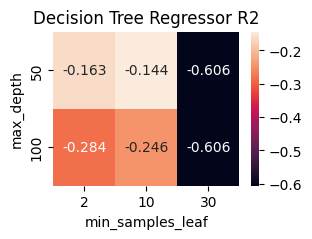

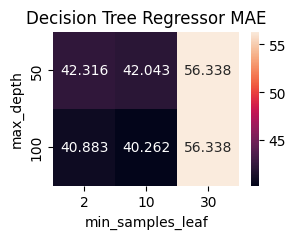

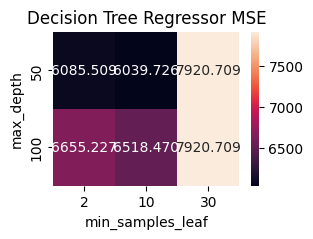

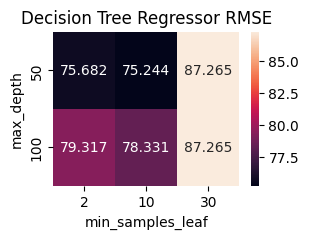

In [23]:
#Plot graphs
def plot_results(res):
    x_length = len(res['min_samples_leaf'].unique())
    y_length = len(res['max_depth'].unique())
    r2_pivot = res.pivot(index='max_depth', columns='min_samples_leaf', values='R^2')
    mae_pivot = res.pivot(index='max_depth', columns='min_samples_leaf', values='MAE')
    mse_pivot = res.pivot(index='max_depth', columns='min_samples_leaf', values='MSE')
    rmse_pivot = res.pivot(index='max_depth', columns='min_samples_leaf', values='RMSE')

    plt.figure(figsize=(x_length, y_length))
    sns.heatmap(r2_pivot, annot=True, fmt=".3f")
    plt.title('Decision Tree Regressor R2')
    plt.xlabel('min_samples_leaf')
    plt.ylabel('max_depth')
    plt.show()

    plt.figure(figsize=(x_length, y_length))
    sns.heatmap(mae_pivot, annot=True, fmt=".3f")
    plt.title('Decision Tree Regressor MAE')
    plt.show()

    plt.figure(figsize=(x_length, y_length))
    sns.heatmap(mse_pivot, annot=True, fmt=".3f")
    plt.title('Decision Tree Regressor MSE')
    plt.show()

    plt.figure(figsize=(x_length, y_length))
    sns.heatmap(rmse_pivot, annot=True, fmt=".3f")
    plt.title('Decision Tree Regressor RMSE')
    plt.show()

plot_results(results)

## Task 4. Create three buckets and repeat Tasks 2 and 3 for each bucket. 

In this task, you will create three buckets, for prefix length 5, 10 and 15. For each of the bucket, repeat Task 2 and 3.  

You may use the functions you built for Tasks 2 and 3 or reuse code. 

Calculate the error measures (MAE, MSE, RMSE, R^2) and discuss the results. 

In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Group by case_id and create a prefix column
df['prefix'] = df.groupby(column_Sepsis_CaseID).cumcount() + 1

# Buckets for prefix lengths 5, 10, and 15
buckets = {5: None, 10: None, 15: None}

# TODO: Populate the buckets
for prefix_length in buckets.keys():
    # TODO: Populate the bucket with the events that have prefix <= prefix_length
    buckets[prefix_length] = df[df['prefix'] <= prefix_length]

# dataframe to store results
results = pd.DataFrame()

# Create a regressor for each bucket   
regressors = {}

for prefix_length, bucket_df in buckets.items():
    if not bucket_df.empty:
        numerical_cols_in_df = [col for col in numerical_cols if col in bucket_df.columns]
        
        # TODO: Apply the encoding
        bucket_df_Sepsis_ag = agg_per_event_encoding(bucket_df, column_Sepsis_CaseID, column_Sepsis_Activity, numerical_cols_in_df)
        
        # TODO: Retain the event of prefix_length
        bucket_df_Sepsis_ag = bucket_df_Sepsis_ag[bucket_df_Sepsis_ag['prefix'] == prefix_length]
        
        # TODO: Create train-test split 
        X_train_bucket, X_test_bucket, y_train_bucket, y_test_bucket = train_test_time_based_split(
            bucket_df_Sepsis_ag, time_threshold, column_Sepsis_CaseID, 
            column_Sepsis_Activity, column_Sepsis_Timestamps, label_column, irrelevant_Sepsis_Columns
        )

        # clean up irrelevant columns from X_train and X_test
        X_train_bucket_clean = clean_up_removal(X_train_bucket, irrelevant_Sepsis_Columns)
        X_test_bucket_clean = clean_up_removal(X_test_bucket, irrelevant_Sepsis_Columns)

        # TODO: Train a regression model (e.g., Random Forest Regressor)
        regressor = RandomForestRegressor(random_state=42)
        regressor.fit(X_train_bucket_clean, y_train_bucket)

        y_pred = regressor.predict(X_test_bucket_clean)

        # TODO: Evaluate the regressor by calculating the MAE, etc...
        mae = mean_absolute_error(y_test_bucket, y_pred)
        mse = mean_squared_error(y_test_bucket, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_bucket, y_pred)

        # TODO: Store/print your results
        results = pd.concat([results, pd.DataFrame({
            'prefix_length': [prefix_length],
            'MAE': [mae],
            'MSE': [mse],
            'RMSE': [rmse],
            'R^2': [r2]
        })], ignore_index=True)
        regressors[prefix_length] = regressor

print("Results for each prefix length:")
print(results)

Results for each prefix length:
   prefix_length        MAE          MSE       RMSE       R^2
0              5  18.575381  1506.805770  38.817596 -0.153696
1             10  23.735994  2025.843577  45.009372 -0.491026
2             15  28.232890  2063.981578  45.431064 -0.505436


## Task 5. Two Alternative Preprocessing and Encoding Methods

In this task, you will refine the design of your method so far and compare the performance of different preprocessing and encoding methods. **Choose two of the following options**:

A) If you have dropped all features except the *activities* in Task 2, select a few features (e.g., Age, Leukocytes, CRP, Lactic Acid), encode them, and repeat Tasks 2 and 3. Motivate your selection in your report. 

B) If you already included some features in Task 2, drop all features except the encoded *activities*, and repeat Task 3.

C) Engineer a feature called *elapsed time* by computing the time elapsed since the case started until the current event, and repeat Tasks 2 and 3. Evaluate if adding this feature (*elapsed time*) help improve the model performance. 

D) Use *last-state encoding* instead of aggregation encoding, and repeat Tasks 2 and 3. Evaluate if the *last-state encoding* help improve the model performance. 


In [25]:

# # Implementation of B)

# Cross_validation setup
event_folds_indices_train = create_event_folds(X_train, 5, column_Sepsis_CaseID, column_Sepsis_Timestamps)

columns_prefix = ['act']
X_train_clean = clean_up_keep(X_train, columns_prefix, [])
X_test_clean = clean_up_keep(X_test, columns_prefix, [])
y_train_clean = y_train
y_test_clean = y_test

max_depth_values = [50, 100]
min_samples_leaf_values = [2, 10, 30]
results = decision_tree_regression_cv(X_train_clean, y_train_clean, event_folds_indices_train, max_depth_values, min_samples_leaf_values, 5)

# TODO: Evaluate the regressor on the test data and print the errors
best_fit = results.loc[results['R^2'].idxmax()]
best_model = DecisionTreeRegressor(max_depth=int(best_fit['max_depth']), min_samples_leaf=int(best_fit['min_samples_leaf']), min_samples_split=5, random_state=42)
best_model.fit(X_train_clean, y_train_clean)
y_test_pred = best_model.predict(X_test_clean)
print("Best Regressor:")
print_regressor(y_test_clean, y_test_pred, best_fit['max_depth'], best_fit['min_samples_leaf'])

Best Regressor:
max_depth: 50.0
min_samples_leaf: 30.0
Test Data Results:
MAE: 36.92650455474169
MSE: 2016.6514575294316
RMSE: 44.90714261149814
R^2: -0.5825499463362112


In [26]:
# # Implementation of C)

# Without elapsed_time
columns_prefix_to_keep = ['act']
X_train_clean = clean_up_keep(X_train, columns_prefix_to_keep, [])
X_test_clean = clean_up_keep(X_test, columns_prefix_to_keep, [])
y_train_clean = y_train
y_test_clean = y_test

best_model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=10, min_samples_split=5, random_state=42)
best_model.fit(X_train_clean, y_train_clean)
y_test_pred = best_model.predict(X_test_clean)

print("Regressor without elapsed_time:")
print_regressor(y_test_clean, y_test_pred, 50, 10)

# With elapsed_time
columns_prefix_to_keep = ['act']
columns_to_keep = ['elapsed_time']
X_train_clean = clean_up_keep(X_train, columns_prefix_to_keep, columns_to_keep)
X_test_clean = clean_up_keep(X_test, columns_prefix_to_keep, columns_to_keep)
y_train_clean = y_train
y_test_clean = y_test

best_model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=10, min_samples_split=5, random_state=42)
best_model.fit(X_train_clean, y_train_clean)
y_test_pred = best_model.predict(X_test_clean)

print("\n")
print("Regressor with elapsed_time:")
print_regressor(y_test_clean, y_test_pred, 50, 10)

Regressor without elapsed_time:
max_depth: 50
min_samples_leaf: 10
Test Data Results:
MAE: 37.3190038682707
MSE: 2093.835634855747
RMSE: 45.75844878113491
R^2: -0.6431195679382535


Regressor with elapsed_time:
max_depth: 50
min_samples_leaf: 10
Test Data Results:
MAE: 40.67259045565973
MSE: 3182.77135085392
RMSE: 56.41605578958813
R^2: -1.4976525376700063


## Task 6.  Report your results and discuss your findings

By now, you have trained and applied a regressor and evaluated its performance on 
(1) the non-bucketed training and test set with all possible prefix length. 
(2) three buckets of different prefix length. 
(3 & 4) and two other methods you tried (e.g., a different encoding or with additional features). 

You have created tables or figures which you can add to your report. 

Create an overview table or figure that compares the performance of each method on the data set, for example, see the table here below. 


Discuss your findings and reflect on the following questions in your report:
- According to the error measures, which one would you suggest as the optimal method (preprocessing + encoding + algorithm)? 
- Are there any discrepancies between the MAE, MSE, RMSE, and R^2 measures in terms of which model/method performs the best? If yes, how would you explain these discrepancies. 
- Which one of the MAE, MSE, RMSE, and R^2 would you use for selecting the model? Why?
- Which one of the encoding would you suggest for this data set? Why?
- Which features have a big influence on predicting the remaining time?





| Encoding | Model | Training MAE  | Test MAE |  Training MSE  |  Test MSE  | Training R^2 | Test R^2 |... |
|------|------|------|------|------|------|------|------|-----|
|  Agg-state and no bucketing |  RF regressor |  |  | || | |
|  Agg-state and prefix length 5 |RF regressor       |  |  | || | |
|   Agg-state and prefix length 10 |RF regressor     |  |  | || | |
|   Agg-state and prefix length 15 |RF regressor     |  |  | || | |
|   last-state |RF regressor    |  |  | || | |
|   last-state + additional features |RF regressor    |  |  | || | |












## Bonus Tasks 

We would like to challenge you with the following bonus tasks. For each task that is successfully completed, you may obtain max. 0.5 extra point added to the total 14 points. 

1. Train a MLP for regression. (If you have used MLP for Task 3, then train another regressor of interest. Evaluate the performance. Explain this in your report.)
2. Train an Autoencoder for feature reduction/learning and evaluate whether it helps improve the performance. Explain this in your report.

